In [1]:
'''
Relied heavily on https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
'''

import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision.transforms as transforms
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        #print(f"{img_path}, {mask_path}")
        img = read_image(img_path)
        mask = read_image(mask_path)

        resize = transforms.Resize(size=(256, 256), interpolation=Image.NEAREST)
        img = resize(img)
        mask = resize(mask)

        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # number of different objects.
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class - pedestrian
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
# Download the dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data

# Navigate to the data directory and unzip the file
!cd data && unzip PennFudanPed.zip

--2024-06-19 03:34:50--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip.5’

PennFudanPed.zip.5  100%[===================>]  51.23M  69.9MB/s    in 0.7s    

2024-06-19 03:34:51 (69.9 MB/s) - ‘data/PennFudanPed.zip.5’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import requests


def download_file(url, local_filename):
    # Note: local_filename should be the path where you want to save the file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)


# URLs of the files you want to download
urls = [
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py",
]

# Download each file
for url in urls:
    filename = url.split("/")[-1]
    download_file(url, filename)
    print(f"Downloaded {filename}")

Downloaded engine.py
Downloaded utils.py
Downloaded coco_utils.py
Downloaded coco_eval.py
Downloaded transforms.py


In [4]:
from torchvision.transforms import v2 as T
import torchvision.transforms as transforms


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [5]:
!pip install pycocotools

In [6]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset("data/PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset("data/PennFudanPed", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn
)

tensor([1])


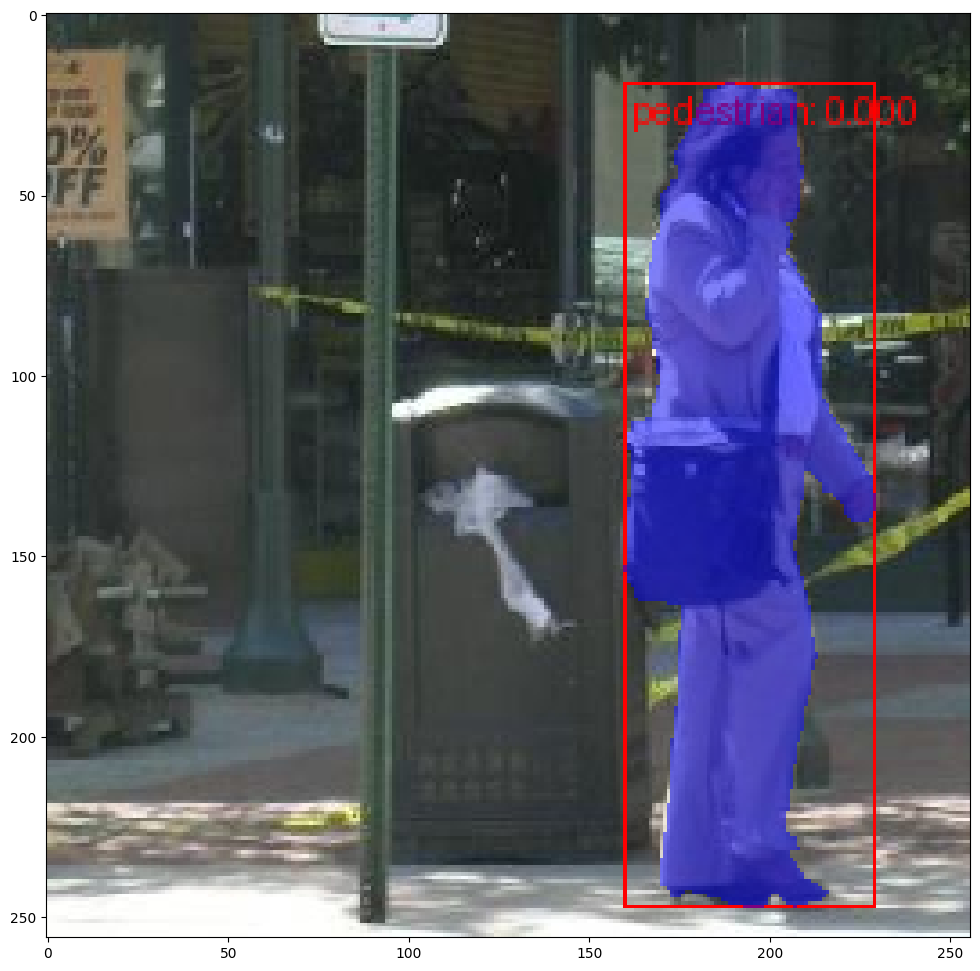

In [7]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import matplotlib.pyplot as plt

x_data, train_labels = next(iter(data_loader_test))
image = x_data[0]
my_dict = train_labels[0]
masks = my_dict['masks']

print(my_dict['labels'])

class_dict = {
    0: "background",
    1: "pedestrian"
}
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

dummy_score = [0] * len(my_dict["boxes"])

pred_labels = [
    f"{class_dict[int(label)]}: {score:.3f}" for label, score in zip(my_dict["labels"], dummy_score)
]
pred_boxes = my_dict["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (my_dict["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

### Add backbone ###

In [8]:
!pip install timm

In [9]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import timm


ft_backbone = timm.create_model(
    "botnet26t_256", pretrained=True, num_classes=0, global_pool=""
)
ft_backbone.out_channels = 2048
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"], output_size=7, sampling_ratio=2
)

num_classes = 2
# I guess this should work for MaskRCNN
model = MaskRCNN(
    backbone=ft_backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)
ft_backbone

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ByobNet(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

In [10]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from typing import Optional, Tuple, Dict

class CustomRCNNTransform(GeneralizedRCNNTransform):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._skip_resize = True  # Add this line to skip resizing
    def resize(
        self,
        image: torch.Tensor,
        target: Optional[Dict[str, torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, Optional[Dict[str, torch.Tensor]]]:
        # Override to skip resizing logic completely if _skip_resize is True
        if self._skip_resize:
            return image, target
        else:
            return super().resize(image, target)


# Example usage with fixed_size and override
transform = CustomRCNNTransform(
    min_size=800,  # This will be ignored in your resizing override
    max_size=1333,  # This will also be ignored
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225],
)

# This transform can now be used in your model pipeline
model.transform = transform

In [ ]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset("data/PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset("data/PennFudanPed", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)


data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn
)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it just for 2 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:14:18  lr: 0.000090  loss: 5.6173 (5.6173)  loss_classifier: 0.6843 (0.6843)  loss_box_reg: 0.0451 (0.0451)  loss_mask: 4.1500 (4.1500)  loss_objectness: 0.6916 (0.6916)  loss_rpn_box_reg: 0.0464 (0.0464)  time: 14.3077  data: 0.0315
Epoch: [0]  [10/60]  eta: 0:11:33  lr: 0.000936  loss: 4.2964 (4.4864)  loss_classifier: 0.6449 (0.6111)  loss_box_reg: 0.0421 (0.0398)  loss_mask: 2.8752 (3.1457)  loss_objectness: 0.6797 (0.6706)  loss_rpn_box_reg: 0.0163 (0.0190)  time: 13.8697  data: 0.0245
Epoch: [0]  [20/60]  eta: 0:09:16  lr: 0.001783  loss: 2.5142 (3.2741)  loss_classifier: 0.4456 (0.4386)  loss_box_reg: 0.0440 (0.0461)  loss_mask: 1.3900 (2.1767)  loss_objectness: 0.6111 (0.5973)  loss_rpn_box_reg: 0.0100 (0.0154)  time: 13.9007  data: 0.0238
Epoch: [0]  [30/60]  eta: 0:06:58  lr: 0.002629  loss: 1.4133 (2.6286)  loss_classifier: 0.1336 (0.3329)  loss_box_reg: 0.0494 (0.0469)  loss_mask: 0.8396 (1.7310)  loss_objectness: 0.4033 (0.5037)  loss_rpn_box_re